# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [8]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [10]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
import pandas as pd
import matplotlib.pyplot as plt
# Hyper parameter tuning
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

* The dataset contains 133 sub-classes
* Each class has diiferent image of dogs
* The dataset is divided into 3 categories- Test, Valid, Train.

In [11]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-04-13 18:58:20--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.216
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  26.4MB/s    in 28s     

2023-04-13 18:58:49 (38.4 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

### Upload data to S3

In [12]:
# Upload metadata
sagemaker_session = sagemaker.Session()
BUCKET = sagemaker_session.default_bucket()
PREFIX = 'Project/dog-breed-dataset'
# ---
DATASET_LOCAL_DIR = "dogImages"

In [13]:
dataset_dir_path = sagemaker_session.upload_data(
    path=DATASET_LOCAL_DIR,
    bucket=BUCKET,
    key_prefix=PREFIX
)

print(f"Dataset directory path on S3 : {dataset_dir_path}")

Dataset directory path on S3 : s3://sagemaker-us-east-1-420152757119/Project/dog-breed-dataset


### Data Exploration

,# train,# valid,# test
Dog Breed,,,
001.Affenpinscher,64,8,8
002.Afghan_hound,58,7,8
003.Airedale_terrier,52,7,6
004.Akita,63,8,8
005.Alaskan_malamute,77,9,10
...,...,...,...
129.Tibetan_mastiff,48,6,6
130.Welsh_springer_spaniel,44,6,5
131.Wirehaired_pointing_griffon,30,4,3



--- Distribution ---

          # train     # valid      # test
count  133.000000  133.000000  133.000000
mean    50.225564    6.278195    6.285714
std     11.863885    1.350384    1.712571
min     26.000000    4.000000    3.000000
25%     42.000000    6.000000    5.000000
50%     50.000000    6.000000    6.000000
75%     61.000000    7.000000    8.000000
max     77.000000    9.000000   10.000000

 --- Split distribution ---


array([[<AxesSubplot:title={'center':'# train'}>,
        <AxesSubplot:title={'center':'# valid'}>],
       [<AxesSubplot:title={'center':'# test'}>, <AxesSubplot:>]],
      dtype=object)

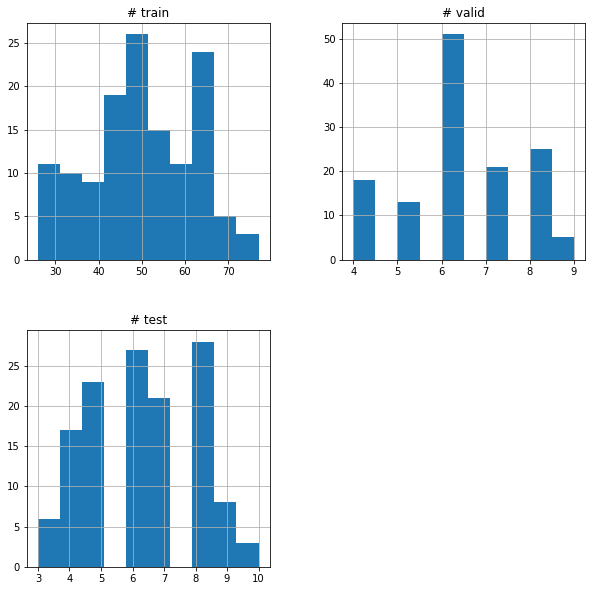

In [14]:
# Number of images for each class & their splits
classes = sorted(os.listdir(os.path.join(DATASET_LOCAL_DIR, 'train')))
num_train_images = []
num_valid_images = []
num_test_images = []

for _class in classes:
    num_train_images.append(len([file for file in os.listdir(os.path.join(DATASET_LOCAL_DIR, 'train', _class))]))
    num_valid_images.append(len([file for file in os.listdir(os.path.join(DATASET_LOCAL_DIR, 'valid', _class))]))
    num_test_images.append(len([file for file in os.listdir(os.path.join(DATASET_LOCAL_DIR, 'test', _class))]))

df_stats = pd.DataFrame(
    {
        "Dog Breed" : list(classes),
        "# train" : num_train_images,
        "# valid" : num_valid_images,
        "# test"  : num_test_images
    }
)
df_stats = df_stats.set_index("Dog Breed")

display(df_stats)

print("\n--- Distribution ---\n")
print(df_stats.describe())

print("\n --- Split distribution ---")
display(df_stats.hist(figsize=(10, 10)))

##### From the EDA we understand :
    * The Train dataset has 50 images of each class
    * The test and valid dataset has about 6 images of each class
    * Some of the images are not of the same size
    * Some images are too big.

In [20]:
# hardcoding data set directory path to avoid re-uploading the data
dataset_dir_path = 's3://sagemaker-us-east-1-420152757119/Project/dog-breed-dataset'
role = sagemaker.get_execution_role()

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [21]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128]),
    "epochs": CategoricalParameter([1, 2])
}

In [22]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [23]:
#TODO: Create estimators for your HPs
cwd = os.getcwd()

estimator = PyTorch(
    entry_point=os.path.join(cwd,  "hpo.py"),
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.c5.2xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=3,
    max_parallel_jobs=3,
    objective_type=objective_type,
)

In [24]:
# TODO: Fit your HP Tuner
tuner.fit({'data': dataset_dir_path}, wait=True) # TODO: Remember to include your data channels

....................................................................................................................................................................................................................................................................................................!


In [25]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator_hyperparameters=best_estimator.hyperparameters()
print(best_estimator_hyperparameters)


2023-04-13 19:59:32 Starting - Preparing the instances for training
2023-04-13 19:59:32 Downloading - Downloading input data
2023-04-13 19:59:32 Training - Training image download completed. Training in progress.
2023-04-13 19:59:32 Uploading - Uploading generated training model
2023-04-13 19:59:32 Completed - Resource retained for reuse
{'_tuning_objective_metric': '"average test loss"', 'batch-size': '"32"', 'epochs': '"2"', 'lr': '0.0018118769541672765', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-2023-04-13-19-40-15-352"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-420152757119/pytorch-training-2023-04-13-19-40-15-352/source/sourcedir.tar.gz"'}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [26]:
# Creating the hyperparameters dictionary
hyperparameters = {
    "batch-size": best_estimator_hyperparameters['batch-size'].strip('"'),
    "lr": best_estimator_hyperparameters['lr'],
    "epochs": best_estimator_hyperparameters['epochs'].strip('"')
}

print(hyperparameters)

{'batch-size': '32', 'lr': '0.0018118769541672765', 'epochs': '2'}


In [27]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [ 
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

In [28]:
# Set up the debugging and Profiler hooks
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile()
)

collection_configs=[
    CollectionConfig(
        name="weights",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="gradients",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="biases",
        parameters={
            "train.save_interval": "5",
            "eval.save_interval": "1"
        }
    ),
    CollectionConfig(
        name="CrossEntopyLoss_output_0", 
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "1",
            "eval.save_interval": "1"
        }
    )
]

debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "5",
        "eval.save_interval": "1"
    },
    collection_configs=collection_configs
)

In [30]:
# TODO: Create and fit an estimator
cwd = os.getcwd()

estimator = PyTorch(
    entry_point=os.path.join(cwd,"train_model.py"),
    base_job_name="Image-classification-Project-debugging",
    role=role,
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config
)
# fitting the estimator
estimator.fit({'data': dataset_dir_path}, wait=True)

2023-04-13 20:16:24 Starting - Starting the training job...LossNotDecreasing: InProgress
ProfilerReport: InProgress
......
2023-04-13 20:17:49 Starting - Preparing the instances for training...
2023-04-13 20:18:22 Downloading - Downloading input data......
2023-04-13 20:19:20 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-13 20:19:29,615 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-13 20:19:29,618 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-13 20:19:29,626 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-13 20:19:29,627 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-13 20:19:29,773 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)

In [34]:
# TODO: Plot a debugging output.
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: Image-classification-Project-debugging-2023-04-13-20-16-24-402
Region: us-east-1


In [35]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-04-13 20:40:59.376 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:53 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-420152757119/Image-classification-Project-debugging-2023-04-13-20-16-24-402/debug-output
[2023-04-13 20:40:59.718 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:53 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 14114 more expected)', IncompleteRead(0 bytes read, 14114 more expected)) while reading s3://sagemaker-us-east-1-420152757119/Image-classification-Project-debugging-2023-04-13-20-16-24-402/debug-output/index/000000000/000000000032_worker_0.json . Will retry now


In [36]:
print(trial.tensor_names())

[2023-04-13 20:41:11.249 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:53 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-04-13 20:41:12.270 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:53 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'ResNet_bn1.bias', 'ResNet_bn1.weight', 'ResNet_conv1.weight', 'ResNet_fc.bias', 'ResNet_fc.weight', 'ResNet_layer1.0.bn1.bias', 'ResNet_layer1.0.bn1.weight', 'ResNet_layer1.0.bn2.bias', 'ResNet_layer1.0.bn2.weight', 'ResNet_layer1.0.bn3.bias', 'ResNet_layer1.0.bn3.weight', 'ResNet_layer1.0.conv1.weight', 'ResNet_layer1.0.conv2.weight', 'ResNet_layer1.0.conv3.weight', 'ResNet_layer1.0.downsample.0.weight', 'ResNet_layer1.0.downsample.1.bias', 'ResNet_layer1.0.downsample.1.weight', 'ResNet_layer1.1.bn1.bias', 'ResNet_layer1.1.bn1.weight', 'ResNet_layer1.1.bn2.bias', 'ResNet_layer1.1.bn2.weight', 'ResNet_layer1.1.bn3.bias', 'ResNet_layer1.1.bn3.weight', 'ResNet_layer

In [37]:
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

418
81


In [38]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [39]:
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


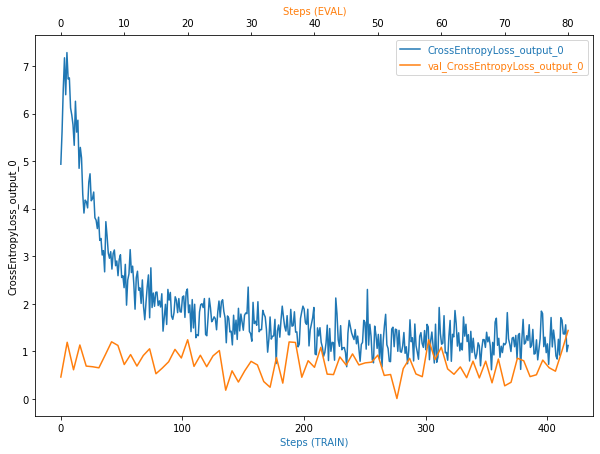

In [40]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

#### From the Graph:
* We notice that the validation loss is less than the Training loss hence the validation dataset is easier than than the Training Dataset.
* The Training Loss is noisy ,hence, we should have chosen a larger batch size

#### If the plot was erronous:
* I need more data more my model
* I need to use a smaller model for fitting like ResNet18.

In [42]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [43]:
! aws s3 ls {rule_output_path} --recursive

2023-04-13 20:37:51     375284 Image-classification-Project-debugging-2023-04-13-20-16-24-402/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-04-13 20:37:51     223197 Image-classification-Project-debugging-2023-04-13-20-16-24-402/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-04-13 20:37:46        192 Image-classification-Project-debugging-2023-04-13-20-16-24-402/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-04-13 20:37:46        200 Image-classification-Project-debugging-2023-04-13-20-16-24-402/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-04-13 20:37:46       2010 Image-classification-Project-debugging-2023-04-13-20-16-24-402/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-04-13 20:37:46        127 Image-classification-Project-debugging-2023-04-13-20-16-24-402/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease

In [44]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-420152757119/Image-classification-Project-debugging-2023-04-13-20-16-24-402/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-420152757119/Image-classification-Project-debugging-2023-04-13-20-16-24-402/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-420152757119/Image-classification-Project-debugging-2023-04-13-20-16-24-402/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-420152757119/Image-classification-Project-debugging-2023-04-13-20-16-24-402/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-

In [45]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [46]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [47]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy(
    initial_instance_count=1, instance_type="ml.t2.medium"
) # TODO: Add your deployment configuration like instance type and number of instances

------------!

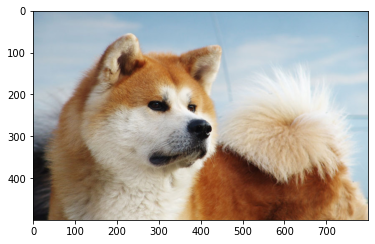

In [48]:
# TODO: Run an prediction on the endpoint
# loading the image
image = plt.imread("dogImages/test/004.Akita/Akita_00263.jpg")
plt.imshow(image)
plt.show()

In [49]:
# processing the image for the model input
# image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
import requests
from PIL import Image
import io
import torchvision.transforms as T

cwd = os.getcwd()
path = os.path.join(cwd, "dogImages/test/004.Akita/Akita_00263.jpg")
pil_img = Image.open(path)

# transforms
preprocess = T.Compose([
   T.Resize(256),
   T.CenterCrop(224),
   T.ToTensor(),
   T.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

image = preprocess(pil_img).unsqueeze(0)
image.shape

[2023-04-13 20:55:22.439 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:53 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


torch.Size([1, 3, 224, 224])

In [50]:
# TODO: Run an prediction on the endpoint
response = predictor.predict(image)

In [ ]:
print(response)
print(f'lenght of response : {len(response[0])}')

[[-13.93563557 -13.36864471 -11.1887579    0.99396622  -5.17858171
   -5.53303099  -9.69655514 -10.79286098 -11.85397053  -7.45871449
   -7.33643579  -8.24444771 -11.75092316  -6.65975237 -11.4899826
  -10.56526279 -13.7297039  -12.20438004  -8.03787899 -14.58847809
  -10.9984169  -14.16690826  -9.43783474  -9.32943249 -18.11701012
  -11.50901413 -14.20369911 -13.41374779 -12.52332878 -11.86092186
  -12.112113   -15.13914967 -14.14340305 -12.92520905 -15.4770155
  -13.25104046 -10.98489952 -12.96285439 -11.93075752 -11.13602829
  -12.52438641 -15.22713184  -5.07118607 -12.98195553  -4.49672318
  -11.69962597 -13.34138203  -9.36025906 -11.08146286  -8.61482334
   -3.2466929  -14.30378723 -10.67412949 -10.54888153 -12.85950756
  -14.64883137 -10.76327419 -11.2497673  -16.06092644 -15.30266094
  -13.10387707 -13.6444931  -15.66762161 -11.14536381 -11.28102112
  -17.00722885  -4.52196884 -12.66307068 -11.23959064  -7.54327011
   -8.21287727 -11.72562313 -16.98291779 -13.38439846 -13.989038